## COVID-19 
### All countries (Johns Hopkins)
#### Data source: https://github.com/CSSEGISandData/COVID-19

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date, timedelta
import re
import json
import folium
import difflib
%matplotlib inline
#plt.style.use('fivethirtyeight')
sns.set()

##### gathering data from https://github.com/CSSEGISandData/COVID-19

In [2]:
df_confirmed_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
#df_recovered_raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

df_confirmed = df_confirmed_raw.melt(id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='date', value_name='cnt')\
    .assign(date=lambda x: pd.to_datetime(x.date))\
    .assign(type='confirmed')

df_deaths = df_deaths_raw.melt(id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='date', value_name='cnt')\
    .assign(date=lambda x: pd.to_datetime(x.date))\
    .assign(type='deaths')

df_covid19 = pd.concat([df_confirmed, df_deaths]).reset_index(drop=True)
df_covid19

,Province/State,Country/Region,Lat,Long,date,cnt,type
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,confirmed
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,confirmed
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,confirmed
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,confirmed
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,confirmed
...,...,...,...,...,...,...,...
36347,Turks and Caicos Islands,United Kingdom,21.694000,-71.797900,2020-04-01,0,deaths
36348,NaN,MS Zaandam,0.000000,0.000000,2020-04-01,2,deaths
36349,NaN,Botswana,-22.328500,24.684900,2020-04-01,1,deaths
36350,NaN,Burundi,-3.373100,29.918900,2020-04-01,0,deaths


get country codes from https://countrycode.org 

In [3]:
# get country codes
url_codes = "https://countrycode.org/"
codes_html = requests.get(url_codes).text
soup = BeautifulSoup(codes_html, 'html.parser')
code_table = soup.find('table', {'data-sort-name':'countrycode'})
df_cc = pd.read_html(str(code_table))[0]
df_cc[['ISO2', 'ISO3']] = df_cc['ISO CODES'].str.split(' / ', expand=True)
df_cc

,COUNTRY,COUNTRY CODE,ISO CODES,POPULATION,AREA KM2,GDP $USD,ISO2,ISO3
0,Afghanistan,93,AF / AFG,29121286,647500,20.65 Billion,AF,AFG
1,Albania,355,AL / ALB,2986952,28748,12.8 Billion,AL,ALB
2,Algeria,213,DZ / DZA,34586184,2381740,215.7 Billion,DZ,DZA
3,American Samoa,1-684,AS / ASM,57881,199,462.2 Million,AS,ASM
4,Andorra,376,AD / AND,84000,468,4.8 Billion,AD,AND
...,...,...,...,...,...,...,...,...
235,Wallis and Futuna,681,WF / WLF,16025,274,NaN,WF,WLF
236,Western Sahara,212,EH / ESH,273008,266000,NaN,EH,ESH
237,Yemen,967,YE / YEM,23495361,527970,43.89 Billion,YE,YEM
238,Zambia,260,ZM / ZMB,13460305,752614,22.24 Billion,ZM,ZMB


In [5]:
#mapping iso codes:
df_covid19['country_key'] =df_covid19['Country/Region']
countries_cc = df_cc['COUNTRY']
df_covid19[~df_covid19['country_key'].isin(countries_cc)]['country_key'].drop_duplicates()


32              Cabo Verde
83     Congo (Brazzaville)
84        Congo (Kinshasa)
86           Cote d'Ivoire
88        Diamond Princess
91                 Czechia
103               Eswatini
127               Holy See
143           Korea, South
174        North Macedonia
207                Taiwan*
225                     US
236            Timor-Leste
241     West Bank and Gaza
248                  Burma
252             MS Zaandam
Name: country_key, dtype: object

In [6]:
 dict_replace=({'Mainland China':'China', 
                       'US':'United States',
                        'UK':'United Kingdom',
                         'Korea, South':'South Korea',
                         'North Macedonia':'Macedonia', 
                         'Others':np.nan, 
                         'Taiwan*':'Taiwan',
                         'Cabo Verde':'Cape Verde',
                         r"Cote d'Ivoire":'Ivory Coast',
                         'Czechia':'Czech Republic',
                       })
df_covid19['country_key'] = df_covid19['country_key'].replace(dict_replace)
df_covid19[~df_covid19['country_key'].isin(countries_cc)]['country_key'].drop_duplicates()

83     Congo (Brazzaville)
84        Congo (Kinshasa)
88        Diamond Princess
103               Eswatini
127               Holy See
236            Timor-Leste
241     West Bank and Gaza
248                  Burma
252             MS Zaandam
Name: country_key, dtype: object

#### merge the data:

In [7]:
df_covid19 = df_covid19.merge(df_cc, left_on='country_key', right_on='COUNTRY', how='left')

In [8]:
df_covid19[df_covid19['ISO3'].isna()]

,Province/State,Country/Region,Lat,Long,date,cnt,type,country_key,COUNTRY,COUNTRY CODE,ISO CODES,POPULATION,AREA KM2,GDP $USD,ISO2,ISO3
83,NaN,Congo (Brazzaville),-4.038300,21.758700,2020-01-22,0,confirmed,Congo (Brazzaville),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,Congo (Kinshasa),-4.038300,21.758700,2020-01-22,0,confirmed,Congo (Kinshasa),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,NaN,Diamond Princess,0.000000,0.000000,2020-01-22,0,confirmed,Diamond Princess,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,Eswatini,-26.522500,31.465900,2020-01-22,0,confirmed,Eswatini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,Holy See,41.902900,12.453400,2020-01-22,0,confirmed,Holy See,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36223,NaN,Holy See,41.902900,12.453400,2020-04-01,0,deaths,Holy See,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36332,NaN,Timor-Leste,-8.874217,125.727539,2020-04-01,0,deaths,Timor-Leste,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36337,NaN,West Bank and Gaza,31.952200,35.233200,2020-04-01,1,deaths,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36344,NaN,Burma,21.916200,95.956000,2020-04-01,1,deaths,Burma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### create main pivot for a major part of the analysis:

In [9]:
df_covid_19_pivot = df_covid19.pivot_table(index=['Country/Region','date'], columns='type', values='cnt', aggfunc='sum')


In [10]:
df_covid_19_pivot.groupby(level=[0,1]).filter(lambda x: x['confirmed']>50).groupby(level=0).cumcount() + 1

Country/Region      date      
Afghanistan         2020-03-24     1
                    2020-03-25     2
                    2020-03-26     3
                    2020-03-27     4
                    2020-03-28     5
                                  ..
West Bank and Gaza  2020-03-28     7
                    2020-03-29     8
                    2020-03-30     9
                    2020-03-31    10
                    2020-04-01    11
Length: 2254, dtype: int64

In [20]:
df_covid_19_pivot

type                       confirmed  deaths
Country/Region date                         
Afghanistan    2020-01-22          0       0
               2020-01-23          0       0
               2020-01-24          0       0
               2020-01-25          0       0
               2020-01-26          0       0
...                              ...     ...
Zimbabwe       2020-03-28          7       1
               2020-03-29          7       1
               2020-03-30          7       1
               2020-03-31          8       1
               2020-04-01          8       1

[12780 rows x 2 columns]

#### create overall data frame for all countries

In [17]:
df_world = df_covid_19_pivot.groupby('date').agg({'confirmed':'sum', 'deaths':'sum'}).reset_index()
df_world

,date,confirmed,deaths
0,2020-01-22,555,17
1,2020-01-23,654,18
2,2020-01-24,941,26
3,2020-01-25,1434,42
4,2020-01-26,2118,56
...,...,...,...
66,2020-03-28,660706,30652
67,2020-03-29,720117,33925
68,2020-03-30,782365,37582
69,2020-03-31,857487,42107


Text(0.5, 1.0, 'World')

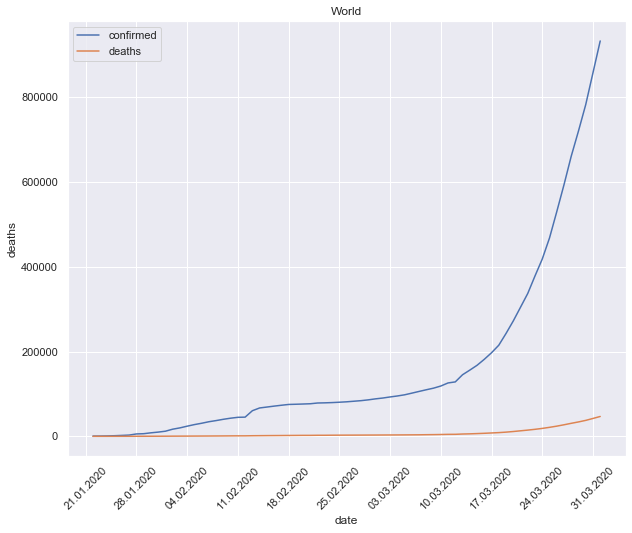

In [18]:
fig = plt.figure(figsize=(10,8))
for ctype in ['confirmed', 'deaths']:
    ax = sns.lineplot(y=ctype, x='date', data=df_world, label = ctype)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#m = mdates.WeekdayLocator()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
ax.xaxis.set_tick_params(rotation=45)
ax.set_title('World')

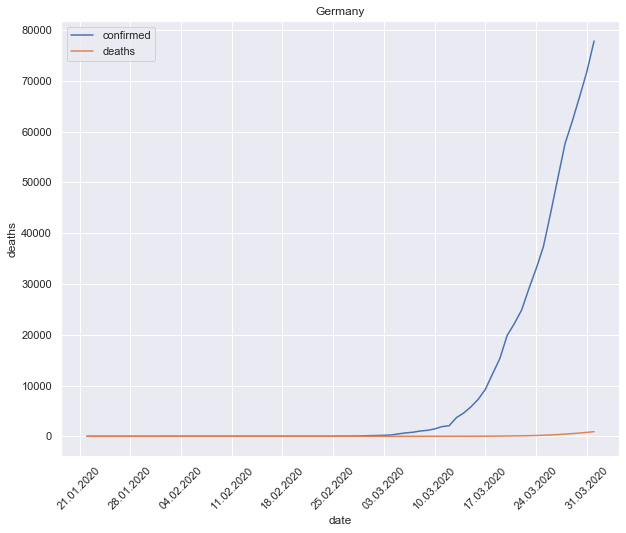

In [25]:
def plot_country(countrycode):
    fig = plt.figure(figsize=(10,8))
    plot_data = df_covid_19_pivot.loc[countrycode]
    for ctype in ['confirmed', 'deaths']:
        ax = sns.lineplot(y=ctype, x=plot_data.index, data=plot_data, label = ctype)
        ax.set_title(countrycode)
        ax.xaxis.set_major_locator(mdates.WeekdayLocator())
        #m = mdates.WeekdayLocator()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
        ax.xaxis.set_tick_params(rotation=45)
plot_country("Germany")


### calculate `X` countries with most confirmed cases:

In [44]:
X = 20
top = list(df_covid_19_pivot.groupby(level=0).confirmed.max().nlargest(X).index)
df_top = df_covid_19_pivot.loc[top].reset_index().set_index(['Country/Region', 'date'])
df_top

type                       confirmed  deaths
Country/Region date                         
Austria        2020-01-22          0       0
               2020-01-23          0       0
               2020-01-24          0       0
               2020-01-25          0       0
               2020-01-26          0       0
...                              ...     ...
United Kingdom 2020-03-28      17312    1021
               2020-03-29      19780    1231
               2020-03-30      22453    1411
               2020-03-31      25481    1793
               2020-04-01      29865    2357

[1420 rows x 2 columns]

##### calculate column with difference to previous day:

In [51]:
df_top['confirmed_diff'] = df_top.groupby(level=0).confirmed.diff()
df_top['confirmed_diff'] = df_top['confirmed_diff'].replace(np.nan, 0).astype(int)
df_top

type                       confirmed  deaths  confirmed_diff  confirme_diff
Country/Region date                                                        
Austria        2020-01-22          0       0               0            0.0
               2020-01-23          0       0               0            0.0
               2020-01-24          0       0               0            0.0
               2020-01-25          0       0               0            0.0
               2020-01-26          0       0               0            0.0
...                              ...     ...             ...            ...
United Kingdom 2020-03-28      17312    1021            2567         2567.0
               2020-03-29      19780    1231            2468         2468.0
               2020-03-30      22453    1411            2673         2673.0
               2020-03-31      25481    1793            3028         3028.0
               2020-04-01      29865    2357            4384         4384.0

[1420 rows x 4 columns]

In [54]:
df_top.reset_index().melt(id_vars=['Country/Region', 'date'])

,Country/Region,date,type,value
0,Austria,2020-01-22,confirmed,0.0
1,Austria,2020-01-23,confirmed,0.0
2,Austria,2020-01-24,confirmed,0.0
3,Austria,2020-01-25,confirmed,0.0
4,Austria,2020-01-26,confirmed,0.0
...,...,...,...,...
5675,United Kingdom,2020-03-28,confirme_diff,2567.0
5676,United Kingdom,2020-03-29,confirme_diff,2468.0
5677,United Kingdom,2020-03-30,confirme_diff,2673.0
5678,United Kingdom,2020-03-31,confirme_diff,3028.0


### Plot a facet grid with top X countries:

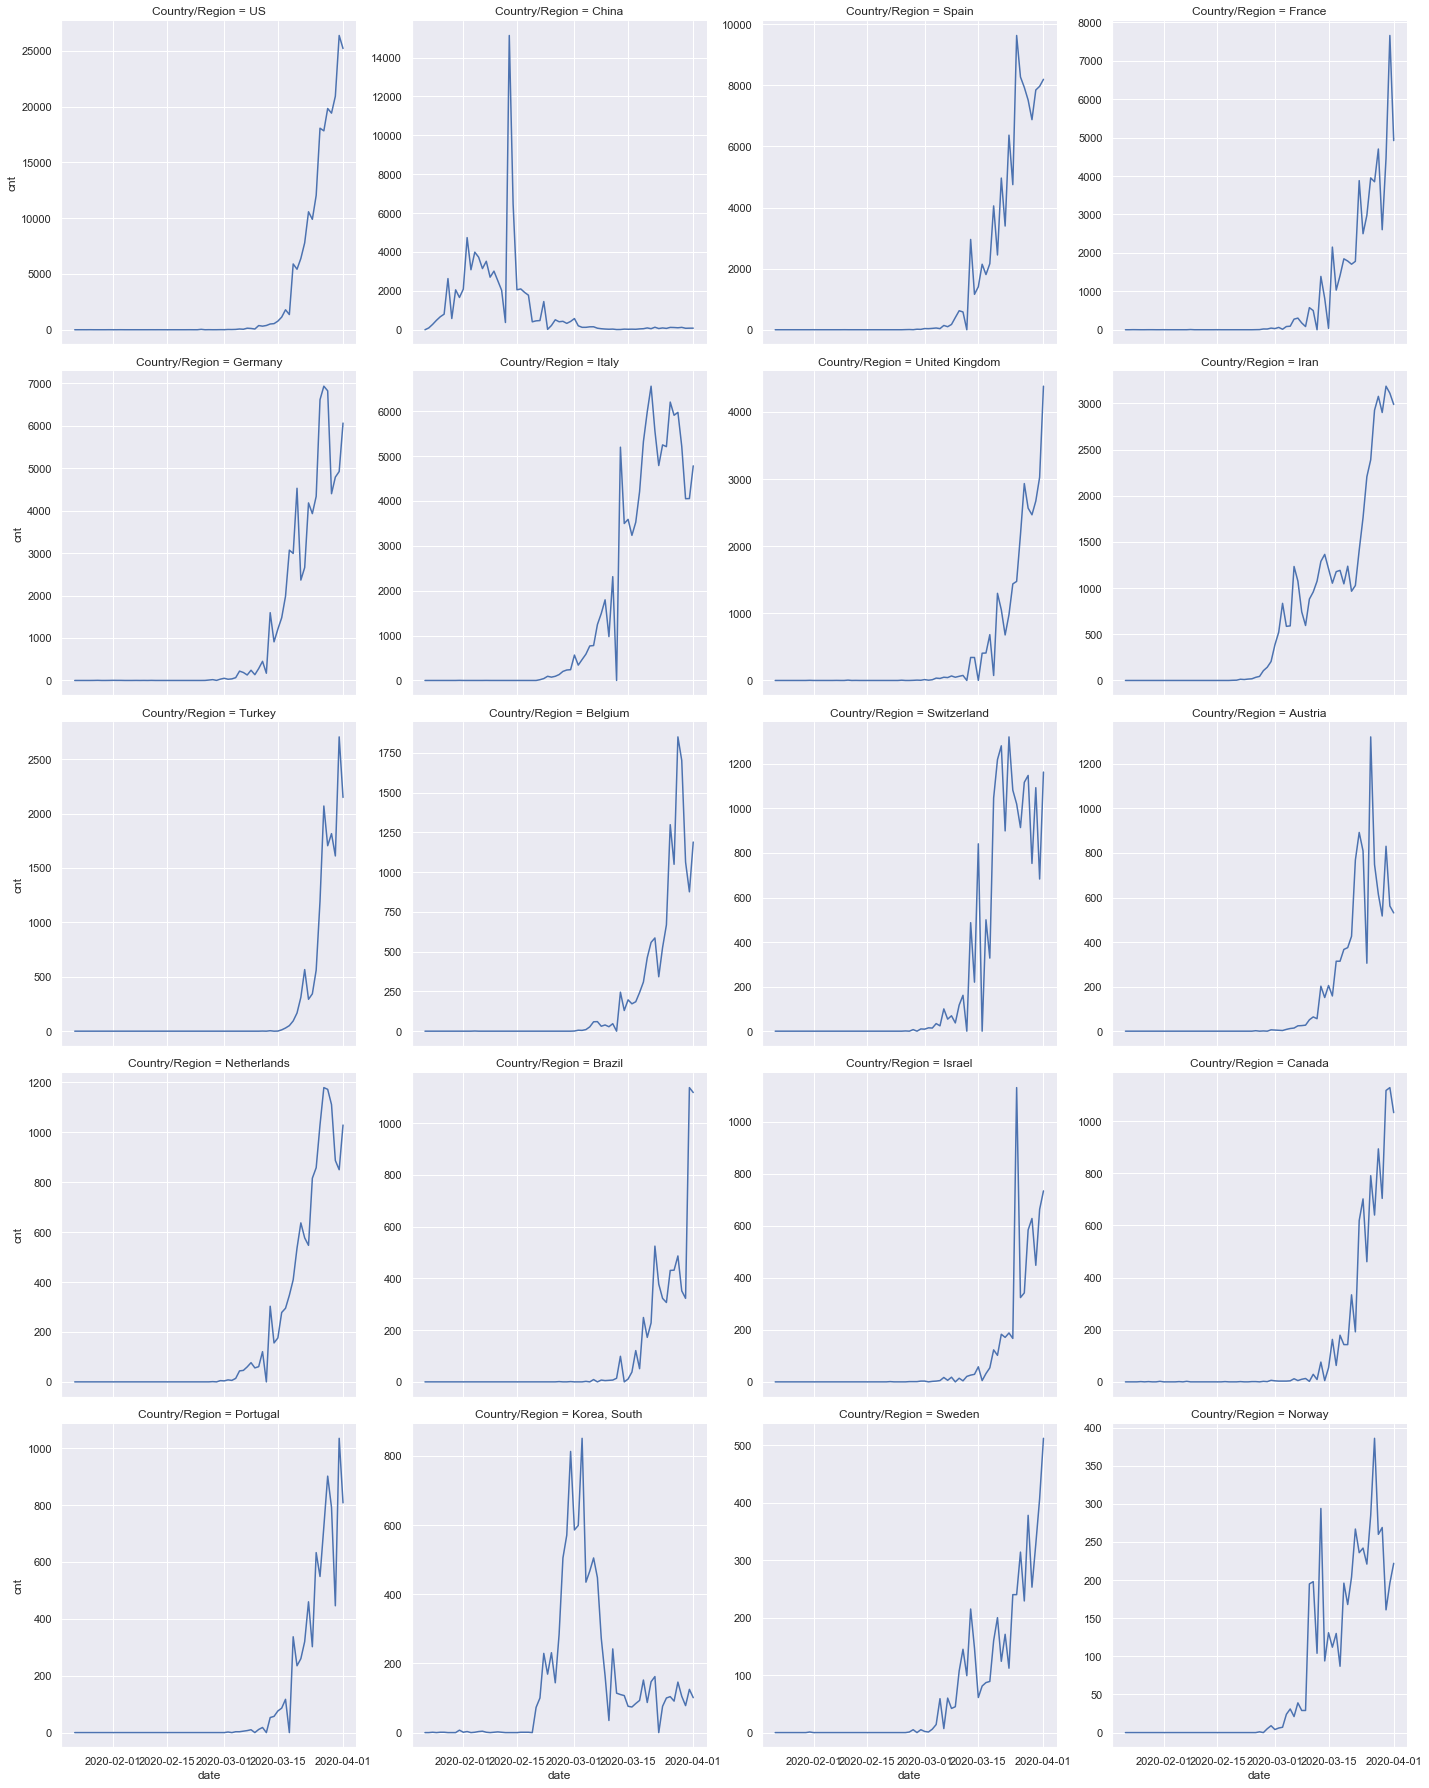

In [55]:
plot_data = df_top.reset_index().melt(id_vars=['Country/Region', 'date'], value_name='cnt').sort_values(by='cnt', ascending=False)
plot_data=plot_data[plot_data.type=='confirmed_diff']
sns.relplot(data=plot_data,  kind='line', x='date', y='cnt', col='Country/Region', col_wrap=4, facet_kws={'sharey':False})

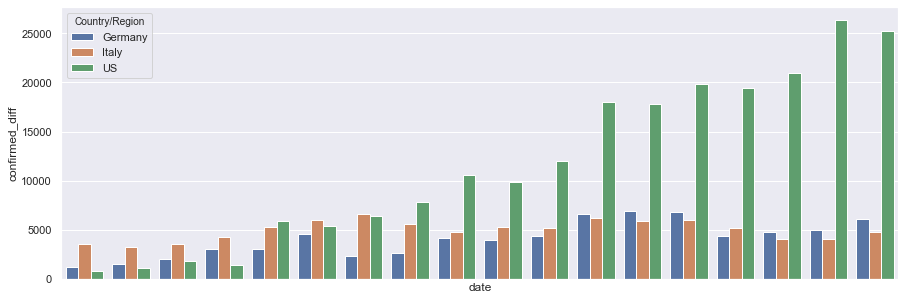

In [77]:
plt.figure(figsize=(15,5))
data = df_top.loc[pd.IndexSlice[['Germany', 'Italy', 'US'], '03/15/2020':],:]
ax=sns.barplot(data=data.reset_index(), x='date',y='confirmed_diff', hue='Country/Region')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_tick_params(rotation=45)

In [40]:
country_geo = './data/custom.geo.json'
df_chloro = df_covid_19_pivot[df_covid_19_pivot['date']=='29/02/2020'].assign(confirmed_log = lambda x: np.log10(x['confirmed'])).replace({-np.inf:np.nan})
m = folium.Map(location=[0, 0], zoom_start=2, tiles='CartoDB dark_matter')

choropleth = folium.Choropleth(
    geo_data=country_geo,
    name='choropleth',
    data=df_chloro,
    columns=['ISO3', 'confirmed_log'],
    key_on='feature.properties.iso_a3',
    fill_color='OrRd',
    fill_opacity=0.7,
    nan_fill_opacity=0,
    line_opacity=0.8,
    legend_name='Confirmed cases (log)'
).add_to(m)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['pop_est'])
)

folium.LayerControl().add_to(m)

m

C:\Users\norma\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:

df_covid_19_pivot.groupby([df_covid_19_pivot.date.dt.week, 'Country/Region']).agg({'confirmed':'sum', 'deaths':'sum', 'recovered':'sum', 'sick':'sum'})

confirmed  deaths  recovered  sick
date Country/Region                                    
4    Afghanistan             0       0          0     0
     Albania                 0       0          0     0
     Algeria                 0       0          0     0
     Andorra                 0       0          0     0
     Angola                  0       0          0     0
...                        ...     ...        ...   ...
12   Uzbekistan            173       0          0   173
     Venezuela             310       0         15   295
     Vietnam               585       0        114   471
     Zambia                 11       0          0    11
     Zimbabwe                7       0          0     7

[1413 rows x 4 columns]

In [42]:
df_countries_date = df_covid_19_pivot.groupby(['date', 'Country/Region']).filter(lambda x: x['confirmed'] > 0)

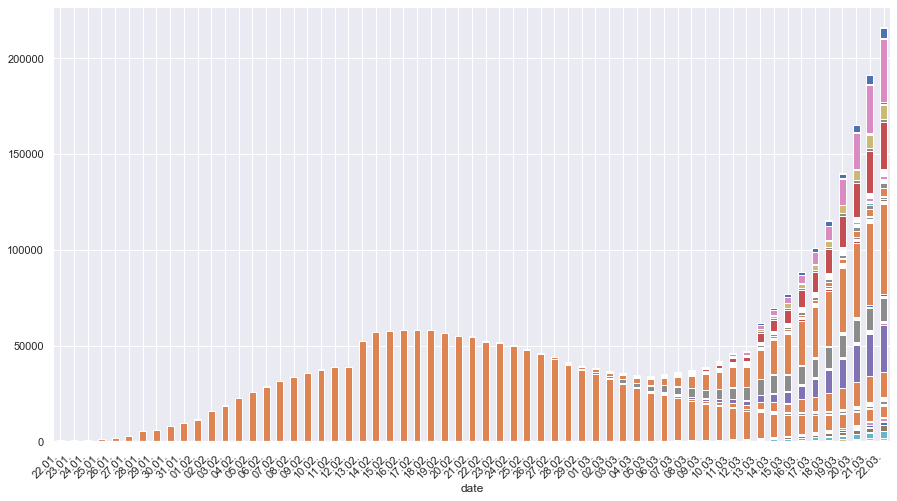

In [43]:
plot_data = df_countries_date.pivot_table(index='date', columns='Country/Region', values='sick', aggfunc='sum')
ax = plot_data.plot(kind='bar', stacked=True, figsize=(15,8))
ax.get_legend().remove()
xdates = plot_data.index.strftime('%d.%m.')
_ = ax.set_xticklabels(xdates,rotation=45, ha='right')

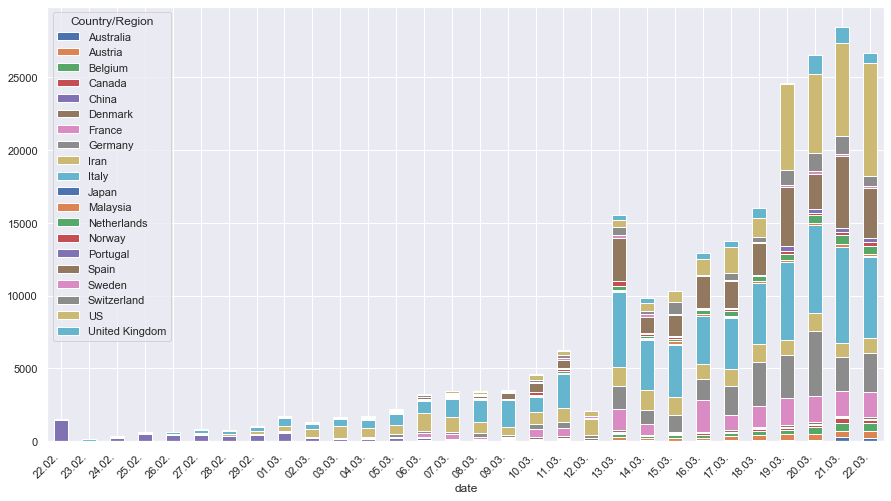

In [44]:
plot_data = df_top.pivot_table(index='date', columns='Country/Region', values='confirmed_diff', aggfunc='sum').loc['22.02.2020':]
ax = plot_data.plot(kind='bar', stacked=True, figsize=(15,8))
xdates = plot_data.index.strftime('%d.%m.')
_ = ax.set_xticklabels(xdates,rotation=45, ha='right')

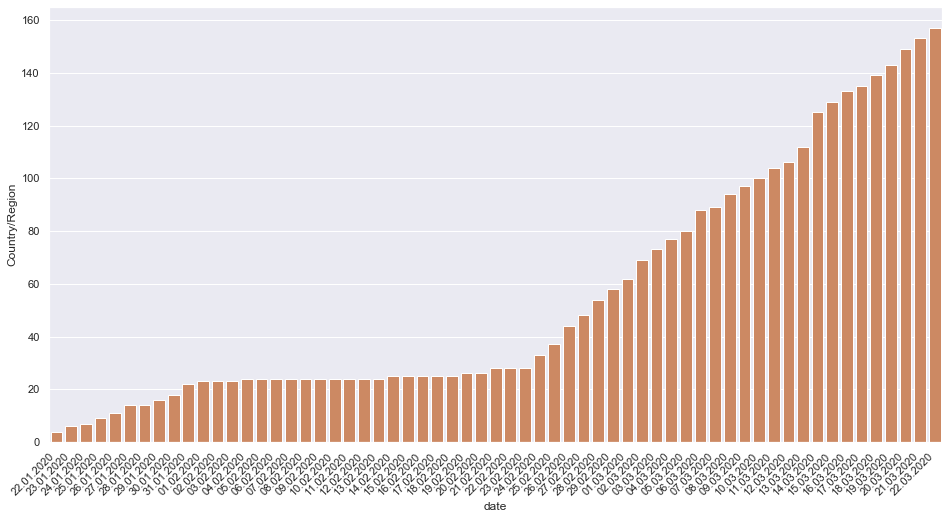

In [45]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = sns.barplot(data=df_countries_date.groupby('date')['Country/Region'].nunique().reset_index(), y='Country/Region', x='date', color="C1")
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
#plt.gcf().autofmt_xdate()
ax.set_xticklabels([pandas_datetime.strftime("%d.%m.%Y") for pandas_datetime in df_countries_date.groupby('date')['Country/Region'].nunique().reset_index()['date']])

_ = ax.set_xticklabels(labels= ax.get_xticklabels(),rotation = 45, ha='right')

In [46]:
df_countries_date

type,Country/Region,ISO3,date,confirmed,deaths,recovered,sick
33,Afghanistan,AFG,2020-02-24,1,0,0,1
34,Afghanistan,AFG,2020-02-25,1,0,0,1
35,Afghanistan,AFG,2020-02-26,1,0,0,1
36,Afghanistan,AFG,2020-02-27,1,0,0,1
37,Afghanistan,AFG,2020-02-28,1,0,0,1
...,...,...,...,...,...,...,...
9514,Zambia,ZMB,2020-03-21,2,0,0,2
9515,Zambia,ZMB,2020-03-22,3,0,0,3
9574,Zimbabwe,ZWE,2020-03-20,1,0,0,1
9575,Zimbabwe,ZWE,2020-03-21,3,0,0,3


In [47]:
df_covid_19_pivot.groupby('Country/Region')

In [48]:
df_covid_19_pivot['ISO3']

0       AFG
1       AFG
2       AFG
3       AFG
4       AFG
       ... 
9572    ZWE
9573    ZWE
9574    ZWE
9575    ZWE
9576    ZWE
Name: ISO3, Length: 9577, dtype: object

In [49]:
df_covid_19_pivot['confirmed_diff'] = df_covid_19_pivot.groupby('ISO3').confirmed.diff()

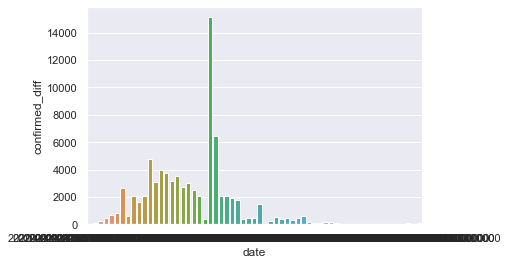

In [50]:
sns.barplot(data= df_covid_19_pivot[df_covid_19_pivot['ISO3']=='CHN'], x='date', y='confirmed_diff')

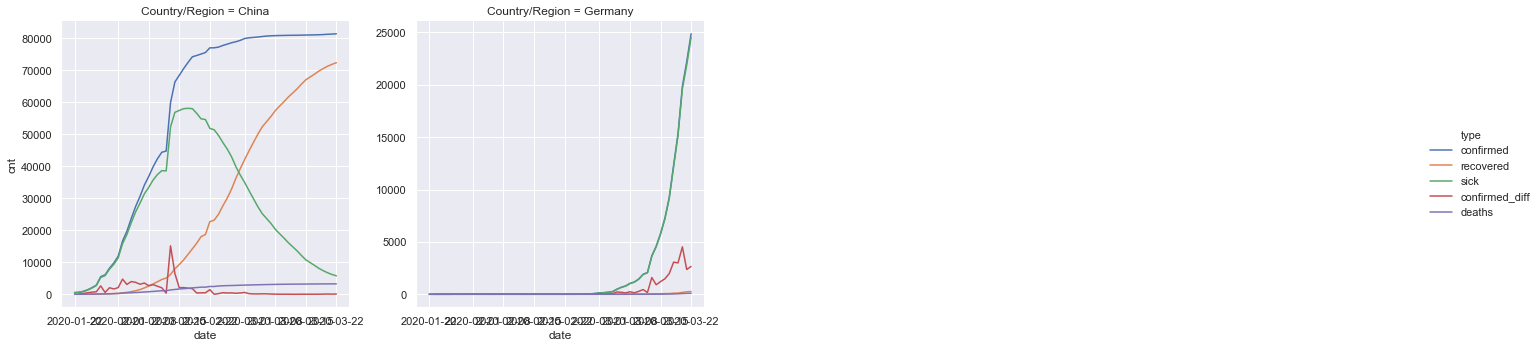

In [51]:
sns.relplot(data=df_covid_19_pivot[df_covid_19_pivot['ISO3'].isin(['CHN', 'DEU'])].melt(id_vars=['Country/Region', 'ISO3', 'date'], value_name='cnt').sort_values(by='cnt', ascending=False), kind='line', x='date', y='cnt', hue='type', col='Country/Region', col_wrap=4, facet_kws={'sharey':False})

In [52]:
df_covid_19_pivot['confirmed_diff'] = df_covid_19_pivot.groupby('ISO3').confirmed.diff()


In [53]:
for i in range(1,5):
    print(df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-i))].nlargest(10, 'confirmed_diff')[['Country/Region', 'confirmed_diff']])

type  Country/Region  confirmed_diff
8966              US          7783.0
4391           Italy          5560.0
8173           Spain          3394.0
3354         Germany          2660.0
3171          France          1745.0
4147            Iran          1028.0
9210  United Kingdom           674.0
8478     Switzerland           670.0
975          Belgium           586.0
6221     Netherlands           576.0
type  Country/Region  confirmed_diff
4390           Italy          6557.0
8965              US          6389.0
8172           Spain          4964.0
3353         Germany          2365.0
3170          France          1705.0
8477     Switzerland          1281.0
9209  United Kingdom          1053.0
4146            Iran           966.0
6220     Netherlands           637.0
974          Belgium           558.0
type  Country/Region  confirmed_diff
4389           Italy          5986.0
8964              US          5423.0
3352         Germany          4528.0
8171           Spain          2447.0
3

In [54]:
date.today() - timedelta(days=1)

datetime.date(2020, 3, 22)

In [55]:
print(df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-1))].sort_values( by='confirmed', ascending=False)[['Country/Region', 'confirmed']])

type                    Country/Region  confirmed
1951                             China      81397
4391                             Italy      59138
8966                                US      33272
8173                             Spain      28768
3354                           Germany      24873
...                                ...        ...
2378                          Djibouti          1
2439                          Dominica          1
2561                        East Timor          1
6831                  Papua New Guinea          1
7502  Saint Vincent and the Grenadines          1

[157 rows x 2 columns]


In [56]:
df = df_covid_19_pivot[df_covid_19_pivot['date']== (pd.Timestamp('now').floor('D') + pd.offsets.Day(-1))].sort_values( by='deaths', ascending=False)[['Country/Region', 'deaths', 'confirmed']]
df['calc_confirmed'] = df['deaths'] / 0.01
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

type                    Country/Region  deaths  confirmed  calc_confirmed
4391                             Italy    5476      59138        547600.0
1951                             China    3265      81397        326500.0
8173                             Spain    1772      28768        177200.0
4147                              Iran    1685      21638        168500.0
3171                            France     674      16176         67400.0
8966                                US     417      33272         41700.0
9210                    United Kingdom     282       5741         28200.0
6221                       Netherlands     180       4216         18000.0
8478                       Switzerland      98       7245          9800.0
3354                           Germany      94      24873          9400.0
975                            Belgium      75       3401          7500.0
4086                         Indonesia      48        514          4800.0
4513                             Japan

In [57]:
rki = pd.read_csv('./data/rkicsv.csv')

In [58]:
df_rki = pd.read_html('https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html;jsessionid=9872726E3BB3EC812BDEB5078D49182E.internet071')[0]

HTTPError: HTTP Error 403: Forbidden

In [ ]:
df_rki.to_csv('./data/rki_germany_09022020.csv')

In [ ]:
df_c = df_covid_19_pivot.copy()

In [ ]:
df_c[df_c['ISO3']=='ITA'].set_index('date').resample('1D').confirmed_diff.sum()

In [ ]:
data = df_c[df_c['ISO3'].isin(['DEU','USA','FRA', 'ITA','ESP'])].set_index('date').loc['02/19/2020':]
plt.figure(figsize=(10,8))
ax = sns.lineplot(data=data, x= data.index, y=np.log10(data.confirmed), hue='ISO3')
xdates = ax.get_xticks()
#_ = ax.set_xticklabels(xdates,rotation=45, ha='right')
[pd.to_datetime(d).strftime('%d.%m') for d in xdates]
xdates

In [ ]:
data = df_c.groupby(['ISO3', 'date']).filter(lambda x: x['confirmed']>=50)
data['no_days'] = data.groupby(['ISO3']).date.rank("dense")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_data=data[data['ISO3'].isin(['DEU','ITA','FRA','USA', 'ESP', 'GBR', 'SWE'])]
sns.lineplot(data=plot_data, x='no_days', y=(np.log10(plot_data.confirmed)), hue='ISO3')

In [ ]:
df_covid_19_pivot.set_index('date')['22/02/2020':].sort_index(ascending=False)